<a href="https://colab.research.google.com/github/Yukselendincer/datasceinceproject/blob/main/LangGraph_1_dersPlanlay%C4%B1c%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -U langgraph langchain_openai

In [10]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.4 MB/s eta 0:00:00


In [11]:
import sqlite3
import random
from faker import Faker

fake = Faker()

def kapsamli_veritabani_olustur():
    conn = sqlite3.connect('ders_takip.db')
    cursor = conn.cursor()

    # Mevcut tabloyu temizleyelim (sıfırdan 500 tane oluşturmak için)
    cursor.execute('DROP TABLE IF EXISTS dersler')
    cursor.execute('''
        CREATE TABLE dersler (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            ders_adi TEXT NOT NULL,
            konu TEXT,
            odev_durumu INTEGER, -- 0: Yapılmadı, 1: Yapıldı
            oncelik TEXT,
            tahmini_sure_dk INTEGER
        )
    ''')

    # Kullanabileceğimiz ders ve konu havuzu
    ders_havuzu = [
        "Yöneylem Araştırması", "Veri Bilimi", "Yapay Zeka", "İşletme Yönetimi",
        "Veritabanı Sistemleri", "Algoritmalar", "İstatistik", "Yazılım Mühendisliği",
        "NLP", "Derin Öğrenme"
    ]

    veriler = []
    for _ in range(500):
        ders = random.choice(ders_havuzu)
        konu = f"{ders} - {fake.catch_phrase()}" # Gerçekçi konu başlıkları
        odev = random.choice([0, 1]) # %50 şansla yapıldı/yapılmadı
        oncelik = random.choice(['Yüksek', 'Orta', 'Düşük'])
        sure = random.randint(30, 180) # 30 ile 180 dk arası çalışma süresi

        veriler.append((ders, konu, odev, oncelik, sure))

    cursor.executemany('''
        INSERT INTO dersler (ders_adi, konu, odev_durumu, oncelik, tahmini_sure_dk)
        VALUES (?, ?, ?, ?, ?)
    ''', veriler)

    conn.commit()
    conn.close()
    print("500 adet ders kaydı başarıyla oluşturuldu!")

kapsamli_veritabani_olustur()

500 adet ders kaydı başarıyla oluşturuldu!


   id               ders_adi  \
0   1             İstatistik   
1   2  Veritabanı Sistemleri   
2   3                    NLP   
3   4            Veri Bilimi   
4   5   Yazılım Mühendisliği   
5   6   Yazılım Mühendisliği   
6   7            Veri Bilimi   
7   8       İşletme Yönetimi   
8   9          Derin Öğrenme   
9  10  Veritabanı Sistemleri   

                                                konu  odev_durumu oncelik  \
0          İstatistik - Balanced impactful structure            1   Düşük   
1  Veritabanı Sistemleri - Inverse asynchronous p...            0   Düşük   
2                 NLP - Organic interactive leverage            0    Orta   
3  Veri Bilimi - Vision-oriented asynchronous mid...            1  Yüksek   
4  Yazılım Mühendisliği - Vision-oriented seconda...            1  Yüksek   
5  Yazılım Mühendisliği - Self-enabling empowerin...            0   Düşük   
6  Veri Bilimi - Stand-alone reciprocal pricing s...            1  Yüksek   
7   İşletme Yönetimi - Universa

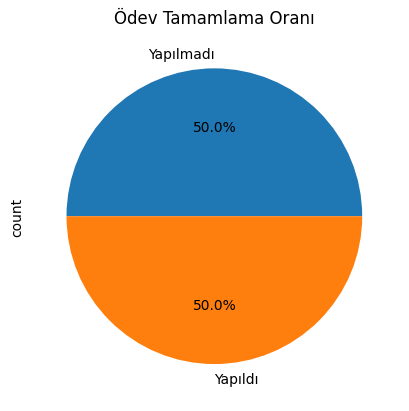

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect('ders_takip.db')
df = pd.read_sql_query("SELECT * FROM dersler", conn)
conn.close()

# İlk 10 satırı göster
print(df.head(10))

# Ödev durumuna göre dağılımı görselleştir
df['odev_durumu'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['Yapılmadı', 'Yapıldı'], title='Ödev Tamamlama Oranı')
plt.show()

In [13]:
import sqlite3
from typing import TypedDict, List, Annotated
import operator
from langgraph.graph import StateGraph, END

# 1. State (Durum) Tanımı
class PlanState(TypedDict):
    ders_listesi: List[dict]
    toplam_sure: int
    mesajlar: Annotated[List[str], operator.add]
    karar: str

# 2. Düğümler (Nodes)

def ders_sorgula_node(state: PlanState):
    """Veritabanından yapılmamış ve yüksek öncelikli dersleri getirir."""
    conn = sqlite3.connect('ders_takip.db')
    cursor = conn.cursor()
    # Rastgele 500 veri içinden kritik olanları çekiyoruz
    cursor.execute("SELECT ders_adi, konu, tahmini_sure_dk FROM dersler WHERE odev_durumu = 0 AND oncelik = 'Yüksek' LIMIT 10")
    rows = cursor.fetchall()
    conn.close()

    dersler = [{"ad": r[0], "konu": r[1], "sure": r[2]} for r in rows]
    toplam = sum(d['sure'] for d in dersler)

    return {
        "ders_listesi": dersler,
        "toplam_sure": toplam,
        "mesajlar": [f"Veritabanından {len(dersler)} kritik ders bulundu. Toplam süre: {toplam} dk."]
    }

def optimizasyon_node(state: PlanState):
    """Eğer süre çok fazlaysa listeyi kısaltır."""
    mevcut_liste = state["ders_listesi"]
    if state["toplam_sure"] > 300: # 5 saat sınırı
        yeni_liste = mevcut_liste[:-2] # Son iki dersi çıkar
        yeni_toplam = sum(d['sure'] for d in yeni_liste)
        return {
            "ders_listesi": yeni_liste,
            "toplam_sure": yeni_toplam,
            "mesajlar": ["Süre 5 saati aştığı için program optimize edildi."]
        }
    return {"mesajlar": ["Süre uygun, plan onaylandı."]}

def final_rapor_node(state: PlanState):
    """Sana son listeyi şık bir formatta sunar."""
    plan_metni = "\n".join([f"- {d['ad']}: {d['konu']} ({d['sure']} dk)" for d in state['ders_listesi']])
    print(f"--- GÜNLÜK ÇALIŞMA PLANI ---\n{plan_metni}\n\nToplam Süre: {state['toplam_sure']} dk")
    return {"mesajlar": ["Rapor sunuldu."]}

# 3. Grafiği Oluşturma
workflow = StateGraph(PlanState)

workflow.add_node("sorgula", ders_sorgula_node)
workflow.add_node("optimize_et", optimizasyon_node)
workflow.add_node("raporla", final_rapor_node)

workflow.set_entry_point("sorgula")

# Koşullu Geçiş: Süre kontrolü
workflow.add_conditional_edges(
    "sorgula",
    lambda x: "fazla" if x["toplam_sure"] > 300 else "uygun",
    {"fazla": "optimize_et", "uygun": "raporla"}
)

workflow.add_edge("optimize_et", "raporla")
workflow.add_edge("raporla", END)

app = workflow.compile()

# 4. Çalıştır
for output in app.stream({"ders_listesi": [], "toplam_sure": 0, "mesajlar": []}):
    print(output)

{'sorgula': {'ders_listesi': [{'ad': 'İşletme Yönetimi', 'konu': 'İşletme Yönetimi - Universal dedicated algorithm', 'sure': 175}, {'ad': 'Veri Bilimi', 'konu': 'Veri Bilimi - Virtual client-server contingency', 'sure': 106}, {'ad': 'Yazılım Mühendisliği', 'konu': 'Yazılım Mühendisliği - Face-to-face motivating software', 'sure': 37}, {'ad': 'Veritabanı Sistemleri', 'konu': 'Veritabanı Sistemleri - Triple-buffered multi-tasking implementation', 'sure': 99}, {'ad': 'İşletme Yönetimi', 'konu': 'İşletme Yönetimi - Quality-focused interactive application', 'sure': 50}, {'ad': 'Veritabanı Sistemleri', 'konu': 'Veritabanı Sistemleri - Up-sized contextually-based matrices', 'sure': 155}, {'ad': 'Yapay Zeka', 'konu': 'Yapay Zeka - Customizable needs-based info-mediaries', 'sure': 62}, {'ad': 'Algoritmalar', 'konu': 'Algoritmalar - Multi-lateral responsive intranet', 'sure': 48}, {'ad': 'NLP', 'konu': 'NLP - Front-line human-resource core', 'sure': 50}, {'ad': 'Derin Öğrenme', 'konu': 'Derin Öğ

In [14]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.1 MB/s eta 0:00:00


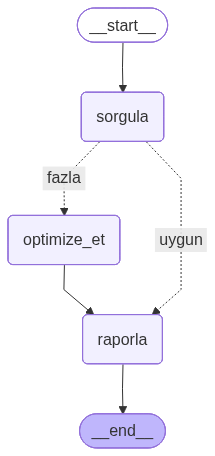

In [15]:
from IPython.display import Image, display

try:
    # app.get_graph().draw_mermaid_png() bazen yerel kütüphane (graphviz) ister.
    # Bu yöntem ise Mermaid API kullanarak her ortamda (Colab dahil) çalışır.
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Doğrudan çizim yapılamadı, alternatif yöntem deneniyor...")
    # Alternatif: Mermaid URL üzerinden görselleştirme
    import pyreadr
    import base64

    mermaid_str = app.get_graph().draw_mermaid()
    print("Grafik Akış Şeması (Mermaid Notasyonu):")
    print(mermaid_str)

In [16]:
!pip install streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 75.9 MB/s eta 0:00:00


In [35]:
%%writefile app.py
import streamlit as st
import sqlite3
import pandas as pd
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Annotated
import operator

# --- VERİTABANI VE YARDIMCI FONKSİYONLAR ---
def get_data():
    try:
        conn = sqlite3.connect('ders_takip.db')
        # Tablonun varlığından emin olalım
        df = pd.read_sql_query("SELECT id, ders_adi, konu, odev_durumu, oncelik, tahmini_sure_dk FROM dersler", conn)
        conn.close()
        return df
    except Exception as e:
        return pd.DataFrame()

def odev_tamamla(ders_id):
    conn = sqlite3.connect('ders_takip.db')
    cursor = conn.cursor()
    cursor.execute("UPDATE dersler SET odev_durumu = 1 WHERE id = ?", (ders_id,))
    conn.commit()
    conn.close()

# --- LANGGRAPH MANTIĞI ---
class PlanState(TypedDict):
    ders_listesi: List[dict]
    toplam_sure: int
    limit: int

def ders_sorgula_node(state: PlanState):
    conn = sqlite3.connect('ders_takip.db')
    cursor = conn.cursor()
    cursor.execute("SELECT id, ders_adi, konu, tahmini_sure_dk FROM dersler WHERE odev_durumu = 0 AND oncelik = 'Yüksek' LIMIT 12")
    rows = cursor.fetchall()
    conn.close()
    dersler = [{"id": r[0], "ad": r[1], "konu": r[2], "sure": r[3]} for r in rows]
    return {"ders_listesi": dersler, "toplam_sure": sum(d['sure'] for d in dersler)}

def optimizasyon_node(state: PlanState):
    current_list = state["ders_listesi"]
    while sum(d['sure'] for d in current_list) > state["limit"] and len(current_list) > 1:
        current_list.pop()
    return {"ders_listesi": current_list, "toplam_sure": sum(d['sure'] for d in current_list)}

workflow = StateGraph(PlanState)
workflow.add_node("sorgula", ders_sorgula_node)
workflow.add_node("optimize", optimizasyon_node)
workflow.set_entry_point("sorgula")
workflow.add_conditional_edges("sorgula", lambda x: "fazla" if x["toplam_sure"] > x["limit"] else "uygun", {"fazla": "optimize", "uygun": END})
workflow.add_edge("optimize", END)
lang_app = workflow.compile()

# --- STREAMLIT ARAYÜZÜ ---
st.set_page_config(page_title="LangGraph Eğitim Danışmanı", layout="wide")
st.title("🎓 Akıllı Ders Takip & Planlayıcı")

# Veriyi başta çekelim
df = get_data()

with st.sidebar:
    st.header("⚙️ Ayarlar")
    zaman_limiti = st.slider("Günlük Çalışma Limiti (Dakika)", 60, 480, 240)
    if st.button("🔄 Verileri Yenile"):
        st.rerun()

    st.divider()
    st.info(f"Hoş geldin, **Yüksel Dinçer Hersek**! Bugünün ders planı aşağıda hazır.")

# Üst Metrikler
col_m1, col_m2, col_m3 = st.columns(3)
if not df.empty:
    col_m1.metric("Toplam Ders Sayısı", len(df))
    col_m2.metric("Tamamlanan", len(df[df['odev_durumu'] == 1]))
    col_m3.metric("Kalan Ödevler", len(df[df['odev_durumu'] == 0]))

col1, col2 = st.columns([1, 1])

with col1:
    st.subheader("📊 Tüm Ders Listesi")

    # 1. Performans için veriyi sadece ihtiyaç duyulduğunda yükleyelim
    if not df.empty:
        # Arama kutusu
        search = st.text_input("🔍 Listede Ara (Ders/Konu)", "")

        # Filtreleme
        display_df = df.copy()
        if search:
            display_df = display_df[display_df['ders_adi'].str.contains(search, case=False) |
                                    display_df['konu'].str.contains(search, case=False)]

        # 2. ÖNEMLİ: st.dataframe yerine st.table veya sınırlı dataframe kullanmak hızı artırır
        # 500 satırı tek seferde basmak yerine ilk 100 satırı gösterip kaydırmayı aktif edelim
        st.dataframe(
            display_df[['id', 'ders_adi', 'oncelik', 'tahmini_sure_dk']].head(100),
            use_container_width=True,
            height=400 # Yüksekliği sabitlemek "yükleniyor" takılmasını engeller
        )
        st.caption(f"Toplam {len(display_df)} kayıttan ilk 100'ü gösteriliyor. Arama yaparak spesifik derslere ulaşabilirsiniz.")
    else:
        st.error("Veritabanı bağlantısı kurulamadı veya tablo boş.")

with col2:
    st.subheader("🤖 LangGraph Plan Önerisi")
    inputs = {"ders_listesi": [], "toplam_sure": 0, "limit": zaman_limiti}
    result = lang_app.invoke(inputs)

    st.success(f"📌 Önerilen Toplam Süre: {result['toplam_sure']} Dakika")

    for ders in result['ders_listesi']:
        with st.expander(f"📖 {ders['ad']} ({ders['sure']} dk)"):
            st.write(f"**Konu:** {ders['konu']}")
            if st.button(f"Tamamla", key=f"btn_{ders['id']}"):
                odev_tamamla(ders['id'])
                st.rerun()

st.divider()
st.caption("Bu proje LangGraph döngüsel mantığı ve SQLite veritabanı ile güçlendirilmiştir.")

Overwriting app.py


In [36]:
!curl https://loca.lt/mytunnelpassword

136.109.183.200

In [37]:
# Tünel oluşturmak için npm paketini kullanıyoruz
!npm install -g localtunnel
# Arka planda streamlit'i başlat
import subprocess
subprocess.Popen(['streamlit', 'run', 'app.py'])

# Localhost adresini dışarıya aç
!npx localtunnel --port 8501

⠙⠹⠸⠼⠴⠦⠧⠇
changed 22 packages in 1s
⠇
⠇3 packages are looking for funding
⠇  run `npm fund` for details
⠇⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸your url is: https://giant-laws-travel.loca.lt
^C


In [31]:
import sqlite3
conn = sqlite3.connect('ders_takip.db')
print(f"Veritabanındaki toplam satır sayısı: {conn.execute('SELECT COUNT(*) FROM dersler').fetchone()[0]}")
conn.close()

Veritabanındaki toplam satır sayısı: 500
